# Автокодери

## Знайомство з даними

Ми будемо працювати з набором даних Fashion-MNIST — це набір даних зображень товарів Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад — це зображення у відтінках сірого розміром 28x28, що належить до одного з 10 класів.


Нашою задачею буде створити автокодер, який вивчить латентне представлення нашого набору даних і навчиться відтворювати його екземпляри.



In [1]:
import gc
gc.collect()

47

In [2]:
import os
import random
from tqdm import tqdm


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# loading data / Завантажимо наші дані з бібліотеки PyTorch.

data_dir = 'data'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

print(train_dataset)
type(train_dataset)

# Створені об’єкти є екземплярами вбудованого типу даних torchvision.datasets.
# Усі набори даних є підкласами torch.utils.data.Dataset, тобто в них реалізовано методи __getitem__ і __len__.
# Отже, усі вони можуть бути передані до torch.utils.data.DataLoader.

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.3MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train


torchvision.datasets.mnist.FashionMNIST

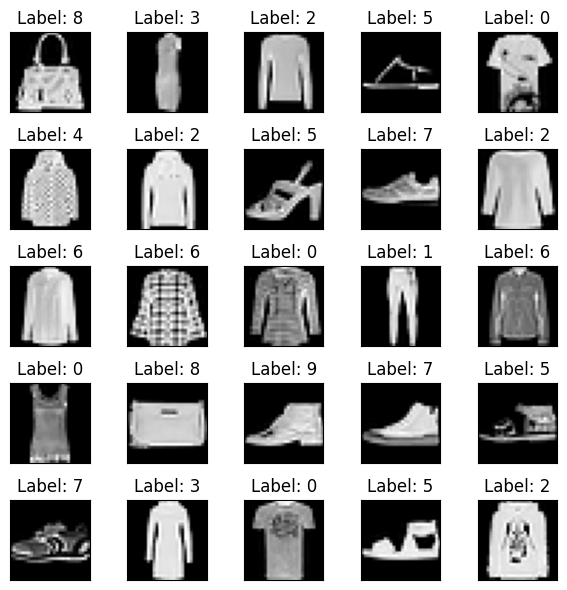

In [4]:
# display images examples

fig, axs = plt.subplots(5, 5, figsize=(6,6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
# Вхідні дані можна представити у вигляді numpy-масивів, але для обробки їх фреймворком PyTorch необхідно представити їх у вигляді тензорів.
# Для цього виконаємо відповідні перетворення та збережемо їх як властивості наших наборів даних.

# data to tensors

train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [7]:
# Створимо також валідаційну вибірку.
# adding validation split

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(len(train_dataset)*0.8), int(m*0.2)])

# Створимо об’єкти DataLoade
batch_size=256
# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Build model

In [8]:
# Визначимо наш згортковий автокодер. Він складатиметься з двох класів: енкодера й декодера.
# Кодер міститиме три згорткові шари і два повністю з'єднані шари.
# Додамо також декілька шарів BatchNorm для регуляризації навчання. Декодер матиме таку саму архітектуру, але у зворотному порядку.
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        # Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        # Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [9]:
class Decoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim=128):
        super().__init__()

        # Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        # Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [10]:
# Ми будемо стискати зображення розміру 28х28 до прихованого простору розміру 4, а потім відновлювати зображення з його латентного представлення.
# Для цього ініціалізуємо основні компоненти нашої моделі.

# Set the random seed for reproducible results
torch.manual_seed(42)

# Initialize the two networks
dim = 4

encoder = Encoder(encoded_space_dim=dim, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=dim, fc2_input_dim=128)

In [11]:
# Переконаємося в коректності виконання цієї операції.
# Example on the untrained model

img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [12]:
# Перш ніж навчати автокодер, нам потрібно визначити основні компоненти навчання: пристрій, на якому відбуватиметься навчання, функцію втрат і алгоритм оптимізації.
# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)

Selected device: cuda


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [13]:
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Training

In [14]:
# Отже, ми визначили всі компоненти нашої моделі й необхідні компоненти тренування. Нам залишилось описати процес навчання й тестування.

# Визначимо функції для тренування й тестування моделі.

# Ми будемо переводити в режими .train() і .eval() як енкодер, так і декодер.

def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [15]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [17]:
# Визначимо функцію для візуалізації результатів.
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)  # використовується для вилучення i-го зображення з тестового набору даних,
            # після чого його буде збільшено на 1 вимір за віссю 0. Цей крок потрібен для того, щоб передати зображення автокодеру;
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))  # використовується для отримання реконструйованого зображення;
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')   # використовується для побудови вихідного зображення.
            # squeeze() видаляє додану раніше розмірність і є необхідною для візуалізації зображення.
            # numpy() перетворює тензор у n-вимірний масив, який є єдиним типом об'єкта, прийнятним для функції plt.imshow.
            # numpy() повертає копію об'єкта тензора в пам'ять процесора.
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

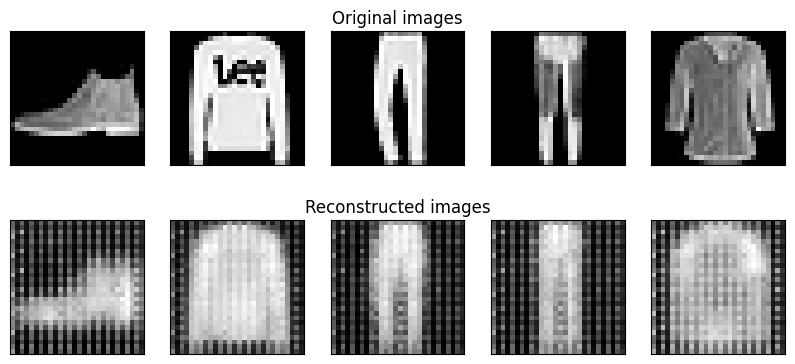

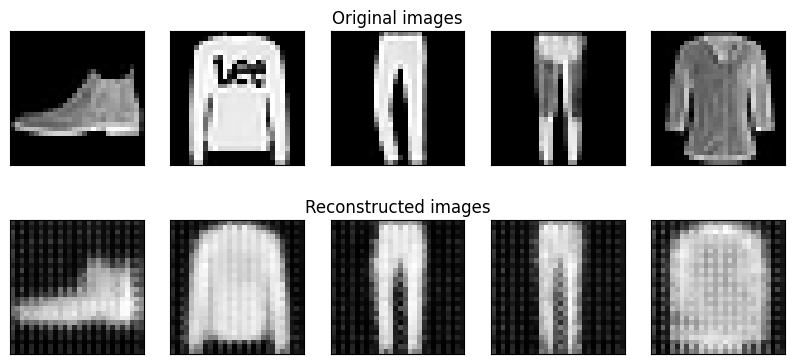

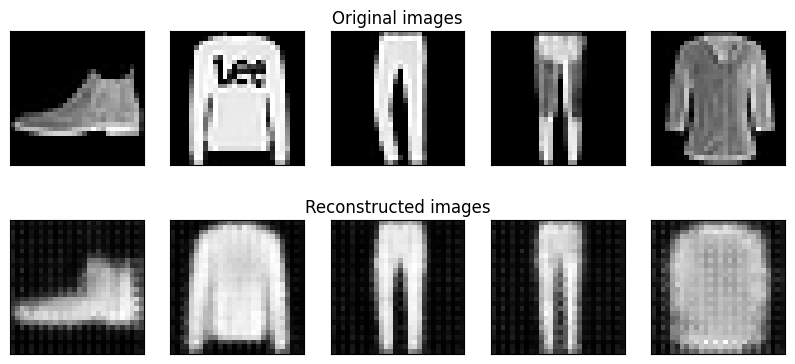

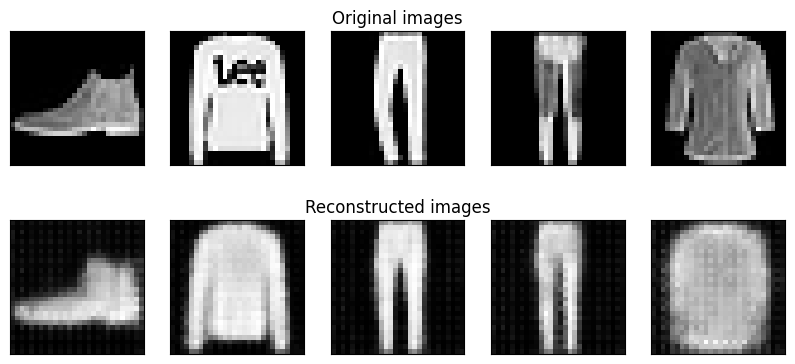

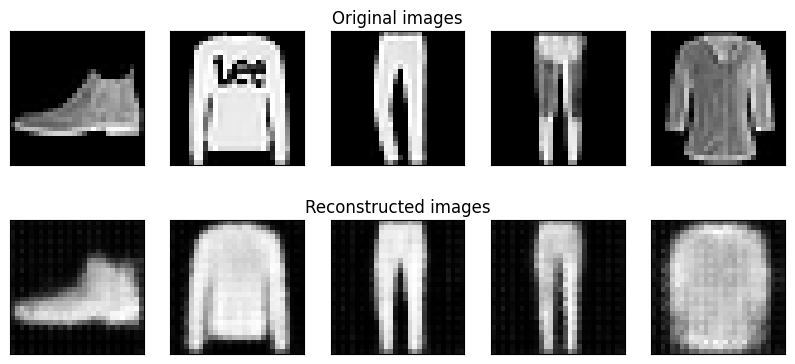

In [18]:
# Усе готово для того, щоб розпочати навчання. Будемо тренувати нашу модель протягом 30 епох і зберігати результати тренування до змінної history.
# Також будемо візуалізувати результати реконструкції після закінчення епохи, щоб візуально оцінити якість реконструкції протягом навчання.

num_epochs = 5
history={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)

    # print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=5)

In [19]:
# Спостерігаємо, що за відведену кількість епох модель значно покращила якість реконструкції.

# Перевіримо значення функції втрат на тестовій вибірці.
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.022523842751979828

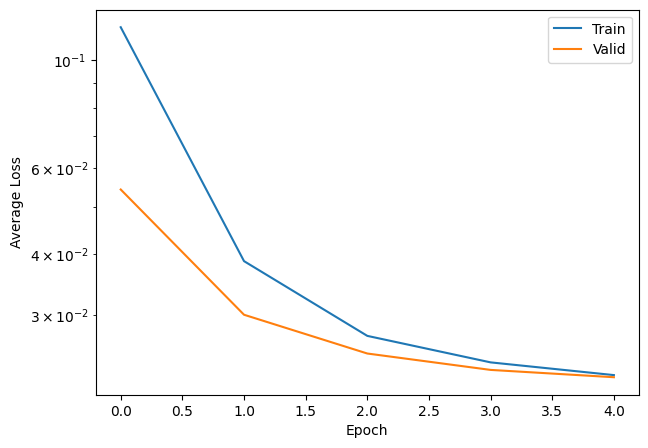

In [20]:
# Значення функції втрат на тестовій вибірці збігається зі значеннями на тренувальній і валідаційній. Отже, явище перенавчання відсутнє.

# Ми також можемо спостерігати, як зменшуються втрати реконструкції з плином часу:
# Train and validation loss

plt.figure(figsize=(7,5))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# Generation

tensor([-0.2864,  0.1547,  0.3670, -0.4899])
tensor([0.9587, 1.2973, 1.3125, 1.0369])


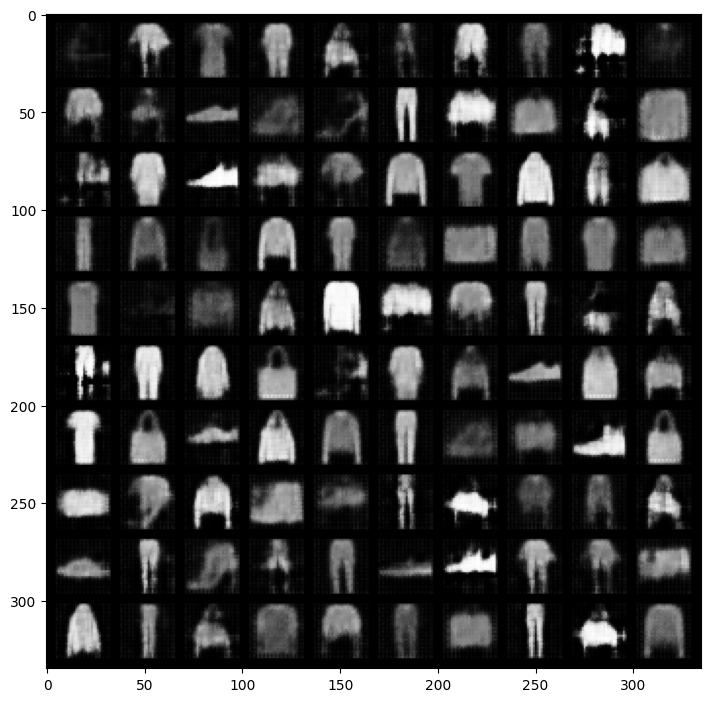

In [21]:
# Щоб згенерувати нові зображення з латентного простору, ми будемо випадковим чином обирати значення з нормального розподілу
# із середнім значенням і стандартним відхиленням закодованих даних.
# Ці вибірки будуть передані декодеру, який створить реконструйовані зображення.

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_top_n(encoder, decoder, dataset, n=10):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # calculate mean and std of latent code, generated takining in test images as inputs
        images, labels = map(list, zip(*[dataset[i] for i in range(10)]))
        images = torch.stack(images).to(device)
        latent = encoder(images)
        latent = latent.cpu()

        mean = latent.mean(dim=0)
        print(mean)
        std = (latent - mean).pow(2).mean(dim=0).sqrt()
        print(std)

        # sample latent vectors from the normal distribution
        latent = torch.randn(128, dim)*std + mean

        # reconstruct images from the random latent vectors
        latent = latent.to(device)
        img_recon = decoder(latent)
        img_recon = img_recon.cpu()

        fig, ax = plt.subplots(figsize=(20, 8.5))
        show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
        plt.show()

show_top_n(encoder, decoder, test_dataset, n=10)

# лід зазначити, що навіть при тому, що ми беремо приклади з латентного простору, є зображення, які не мають жодного сенсу.
# Цей аспект пояснюється тим, що латентний простір автокодера вкрай нерегулярний: близькі точки в латентному просторі можуть створювати дуже різні й часом безглузді візерунки.
# З цієї причини автокодер не дуже добре працює для генеративних цілей.